In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve,classification_report,roc_curve, confusion_matrix
import json,pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif, VarianceThreshold
from skfeature.function.similarity_based import fisher_score
from imblearn.over_sampling import SMOTE
pd.set_option("display.max_columns",None)

# *Problem Statement*

*The classification goal is to predict if the client will subscribe a term deposit.*

# *Data Gathering*

In [3]:
df = pd.read_csv("bank.csv")
df.head()

,age,job,marital status,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,19,student,single,primary,no,103,no,no,cellular,10,jul,104,2,-1,0,unknown,yes
1,19,student,single,unknown,no,0,no,no,cellular,11,feb,123,3,-1,0,unknown,no
2,19,student,single,secondary,no,302,no,no,cellular,16,jul,205,1,-1,0,unknown,yes
3,19,student,single,unknown,no,1169,no,no,cellular,6,feb,463,18,-1,0,unknown,no
4,20,student,single,secondary,no,502,no,no,cellular,30,apr,261,1,-1,0,unknown,yes


### Data Information

The data is related with direct marketing campaigns of a Portuguese banking institution. 

The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed.

The classification goal is to predict if the client will subscribe a term deposit.

##### Attribute Information 

1.  age (numeric)
2.  job : type of job 
(categorical: admin", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services") 
3.  marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4.  education (categorical: "unknown","secondary","primary","tertiary")
5.  default: has credit in default? (binary: "yes","no")
6.  balance: average yearly balance, in euros (numeric) 
7.  housing: has housing loan? (binary: "yes","no")
8.  loan: has personal loan? (binary: "yes","no")
  
**related with the last contact of the current campaign:**

9.  contact: contact communication type (categorical: "unknown","telephone","cellular") 
10.  day: last contact day of the month (numeric)
11.  month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12.  duration: last contact duration, in seconds (numeric)
   
**other attributes:**
 
13.  campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14.  pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15.  previous: number of contacts performed before this campaign and for this client (numeric)
16.  poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

**Output variable (desired target):**

17.  - y - has the client subscribed a term deposit? (binary: "yes","no")

# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4483 entries, 0 to 4482
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             4483 non-null   int64 
 1   job             4483 non-null   object
 2   marital status  4483 non-null   object
 3   education       4483 non-null   object
 4   default         4483 non-null   object
 5   balance         4483 non-null   int64 
 6   housing         4483 non-null   object
 7   loan            4483 non-null   object
 8   contact         4483 non-null   object
 9   day             4483 non-null   int64 
 10  month           4483 non-null   object
 11  duration        4483 non-null   int64 
 12  campaign        4483 non-null   int64 
 13  pdays           4483 non-null   int64 
 14  previous        4483 non-null   int64 
 15  poutcome        4483 non-null   object
 16  y               4483 non-null   object
dtypes: int64(7), object(10)
memory usage: 595.5+ KB


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4483.000000,4483.000000,4483.000000,4483.000000,4483.000000,4483.000000,4483.000000
mean,41.111309,1421.987731,15.915905,264.360027,2.795673,39.796565,0.542940
std,10.559382,3017.124448,8.235155,260.273544,3.116897,99.910253,1.696552
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,67.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,443.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,48.000000,1474.000000,21.000000,329.500000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [6]:
df.duplicated().sum()

0

So, we have 4521 rows. And we have no null values in any feature. Also, we have 7 featues with int values and 10 featutes with object data types. Also no duplicate values. 

In [7]:
# checking null values (NO null values are found)
df.isnull().sum()

age               0
job               0
marital status    0
education         0
default           0
balance           0
housing           0
loan              0
contact           0
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
y                 0
dtype: int64

In [8]:
#  here we can see the data is highly imbalanced 
df["y"].value_counts()

no     3969
yes     514
Name: y, dtype: int64

In [9]:
# defining the function to get counts 
def get_counts(data):
    plt.figure(figsize = (15,5))
    plt.ylabel("Counts",fontsize = 10)
    return  data.value_counts().plot(kind = "bar",cmap='summer')
    plt.show()

Text(0.5, 0, 'Age')

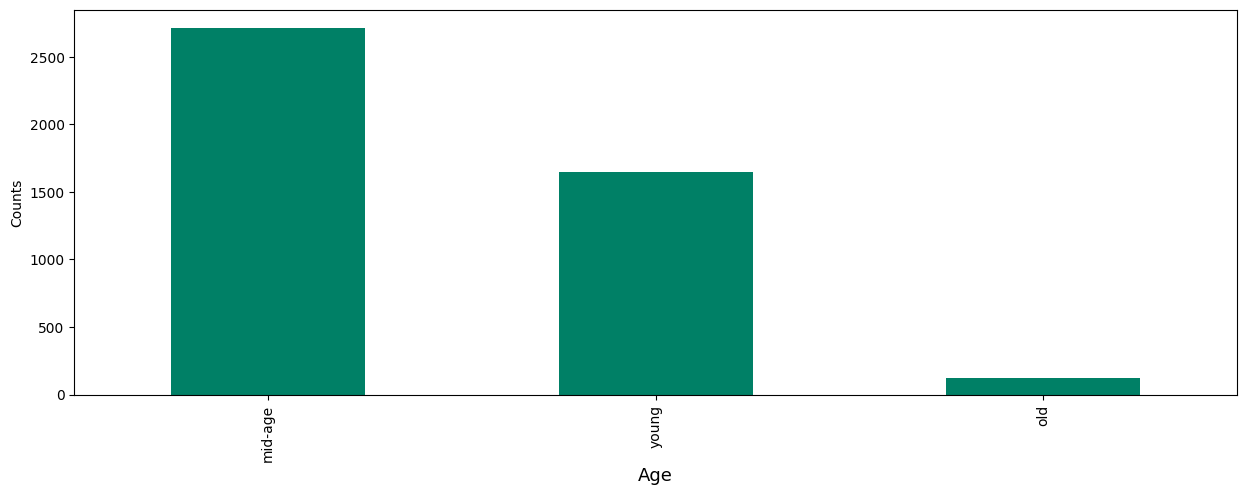

In [10]:
# getting information about counts of the population in each age category.
b = df["age"]
b = pd.cut(b,bins = [18,35,60,90],labels = ["young","mid-age","old"])
get_counts(b)
plt.xlabel("Age",fontsize = 13)

Text(0.5, 0, 'Job')

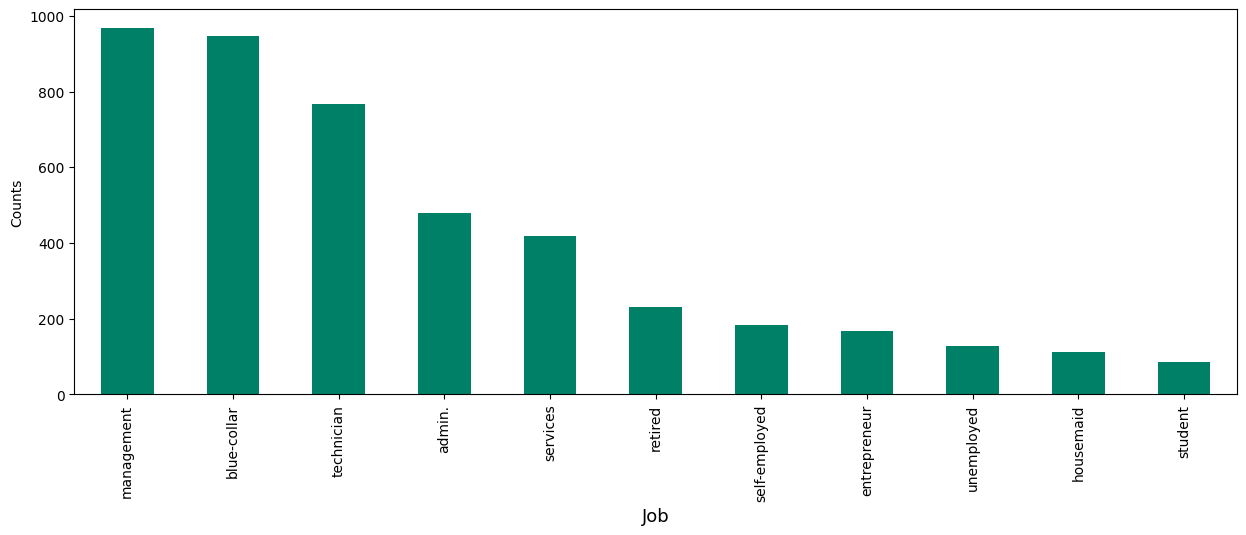

In [11]:
# getting information about counts of the population in each job category.
get_counts(df["job"])
plt.xlabel("Job",fontsize = 13)

Text(0.5, 0, 'Marital Status')

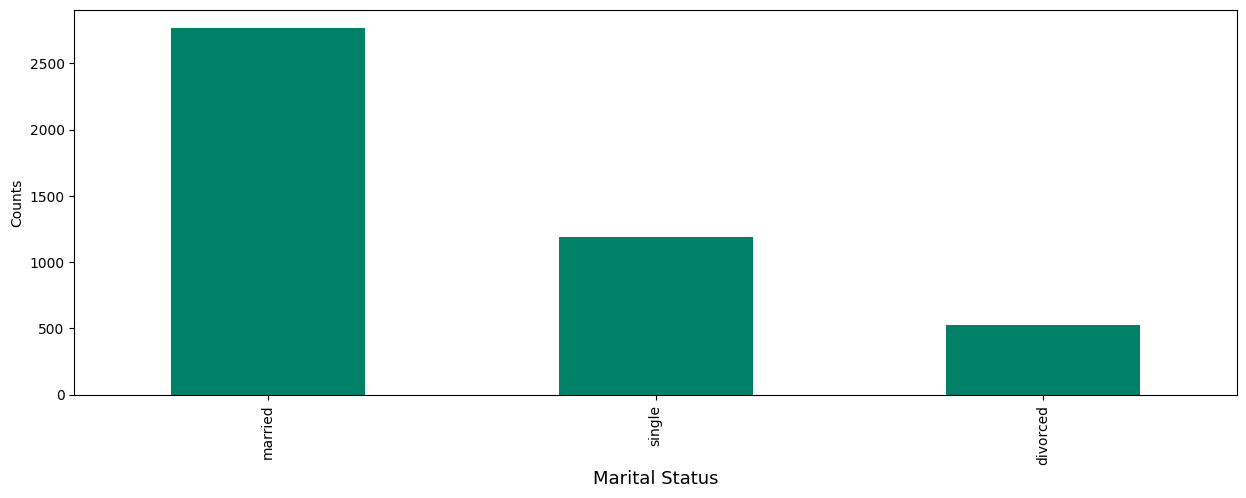

In [12]:
# getting information about counts of the population in each marital category.
get_counts(df["marital status"])
plt.xlabel("Marital Status",fontsize = 13)

Text(0.5, 0, 'Education')

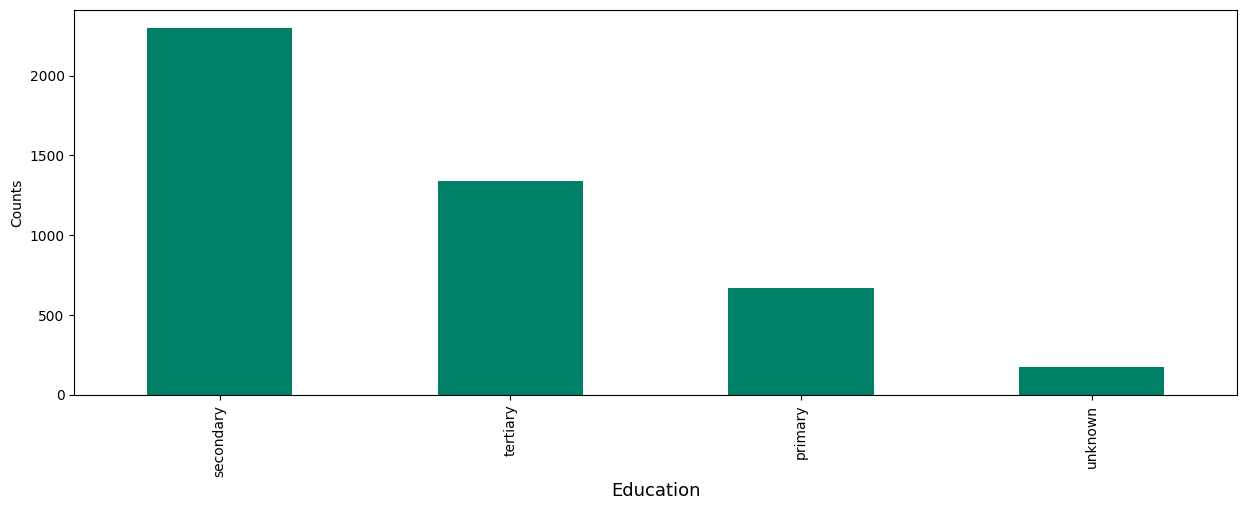

In [13]:
# getting information about counts of the population in each education category.
get_counts(df["education"])
plt.xlabel("Education",fontsize = 13)

Text(0.5, 0, 'Credit in default')

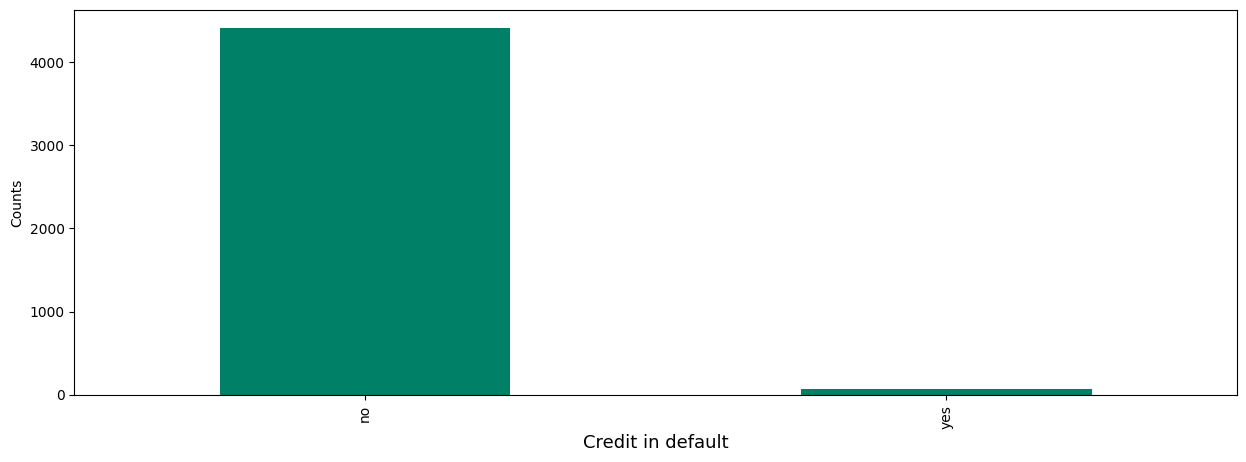

In [14]:
# getting information about counts of the population in each credit category.
get_counts(df["default"])
plt.xlabel("Credit in default",fontsize = 13)

Text(0.5, 0, 'Housing Loan')

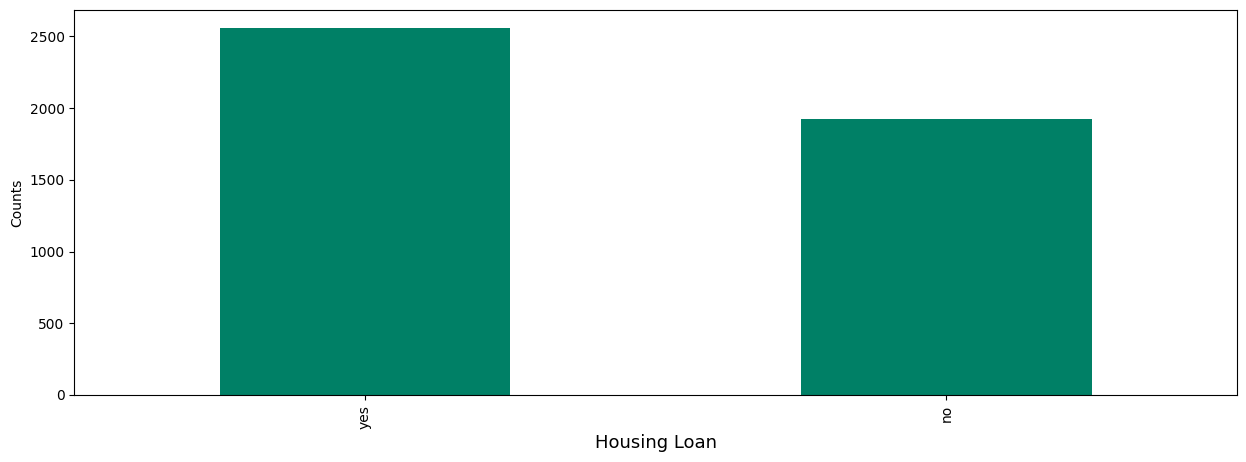

In [15]:
# getting information about counts of the population in each housing loan category.
get_counts(df["housing"])
plt.xlabel("Housing Loan",fontsize = 13)

Text(0.5, 0, 'Personal Loan')

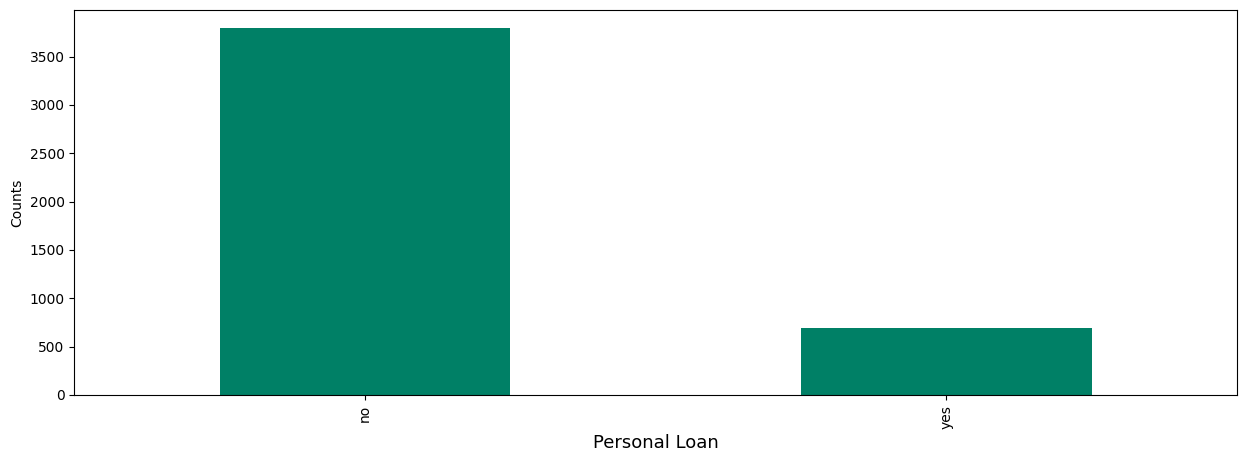

In [16]:
# getting information about counts of the population in each personal loan category.
get_counts(df["loan"])
plt.xlabel("Personal Loan",fontsize = 13)

Text(0.5, 0, 'contact communication type')

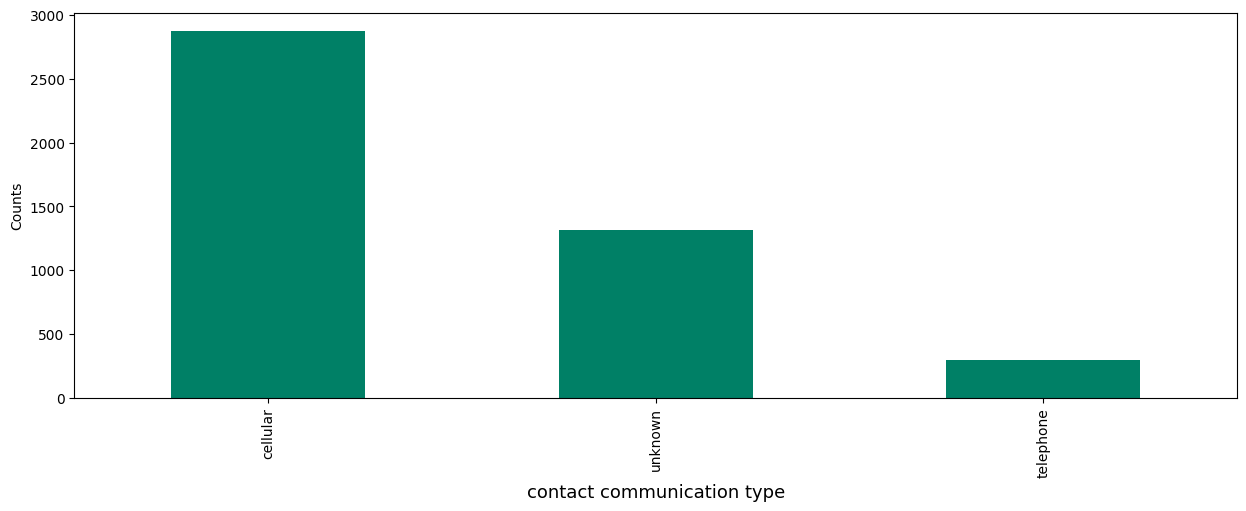

In [17]:
# getting information about counts of the population in each contact communication category.
get_counts(df["contact"])
plt.xlabel("contact communication type",fontsize = 13)

Text(0.5, 0, 'last contact month of year')

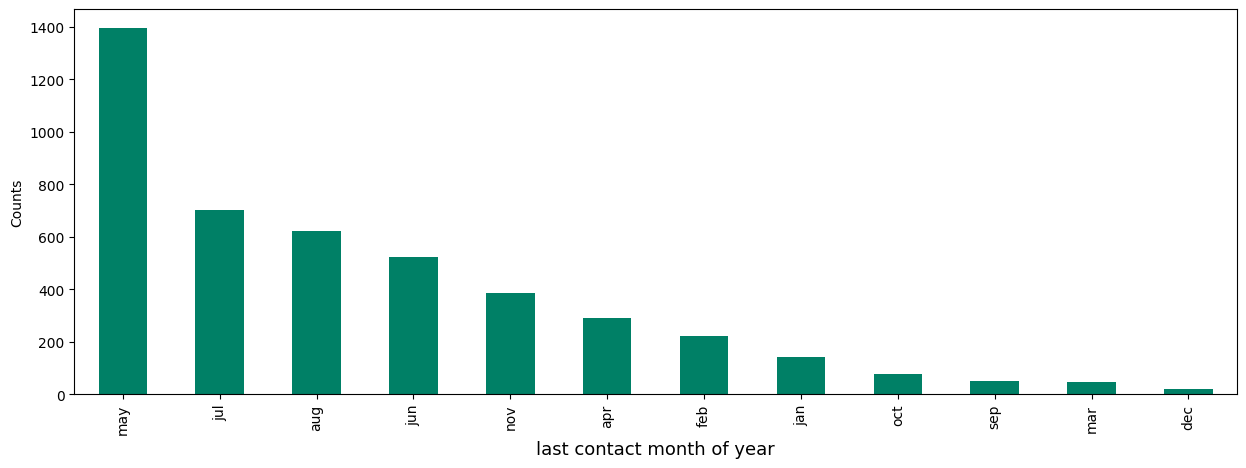

In [18]:
# getting information about counts of the population in each contact last month of year category.
get_counts(df["month"])
plt.xlabel("last contact month of year",fontsize = 13)

Text(0.5, 0, 'Outcome of the previous marketing campaign')

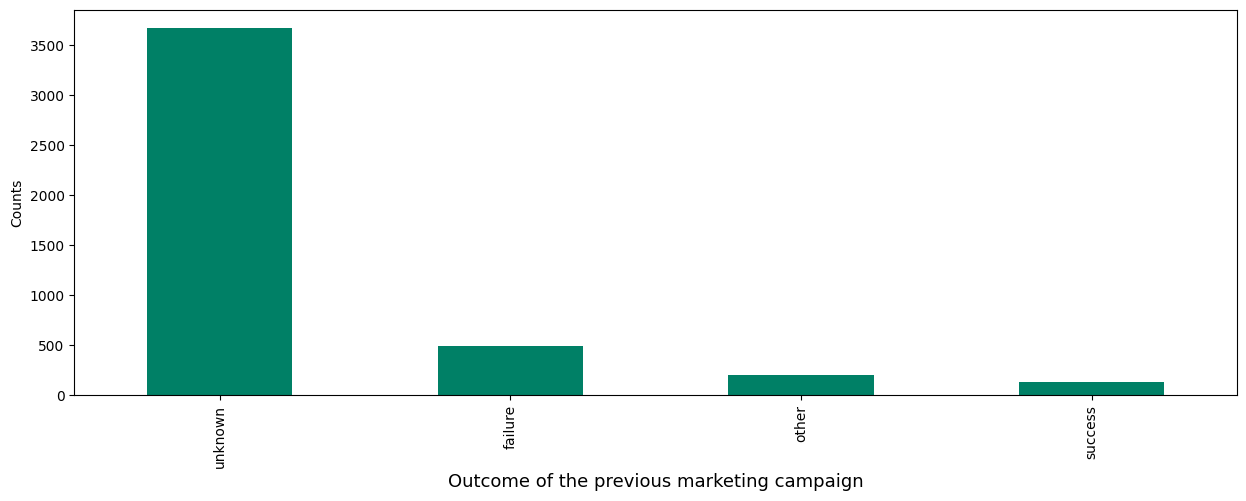

In [19]:
# getting information about counts of the population in each Outcome category.
get_counts(df["poutcome"])
plt.xlabel("Outcome of the previous marketing campaign",fontsize = 13)

In [20]:
# defining a function to get distribution and outliers
def get_distribution(data):
    fig, axes = plt.subplots(1, 2, figsize=(16,4))
    sns.distplot(data, hist = False,ax = axes[0],color="r")
    sns.boxplot(data,ax = axes[1],color="g")
    return plt.show()

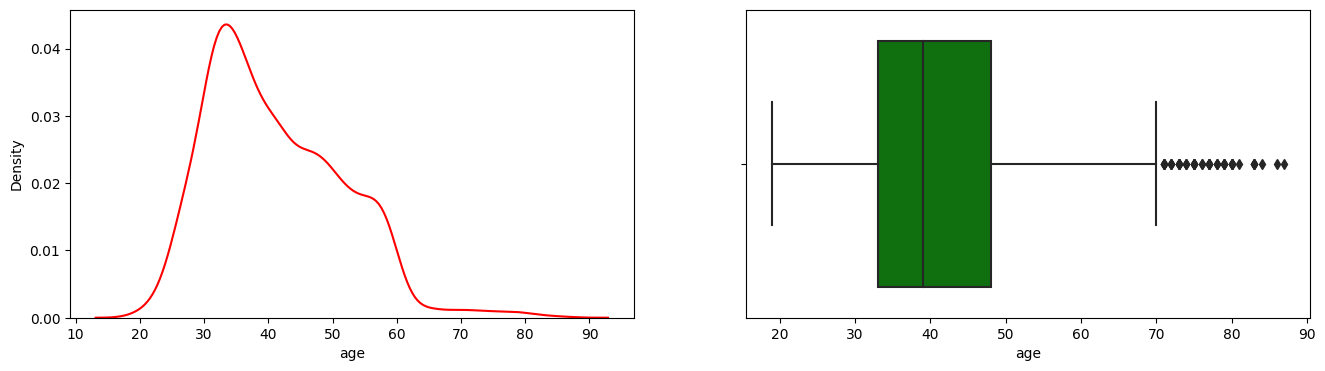

In [21]:
# getting information regarding distribution and outliers of age feature.
get_distribution(df["age"])

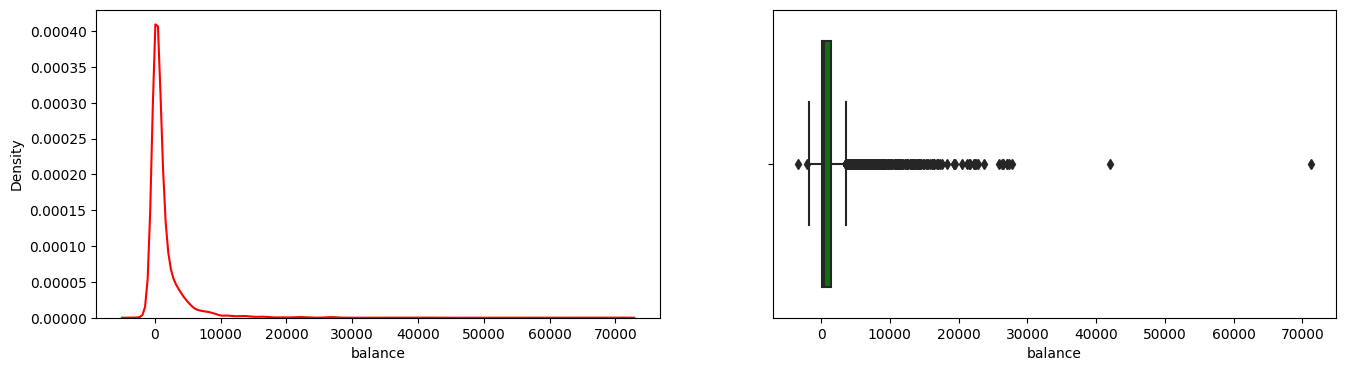

In [22]:
# getting information regarding distribution and outliers of balance feature.
get_distribution(df["balance"])

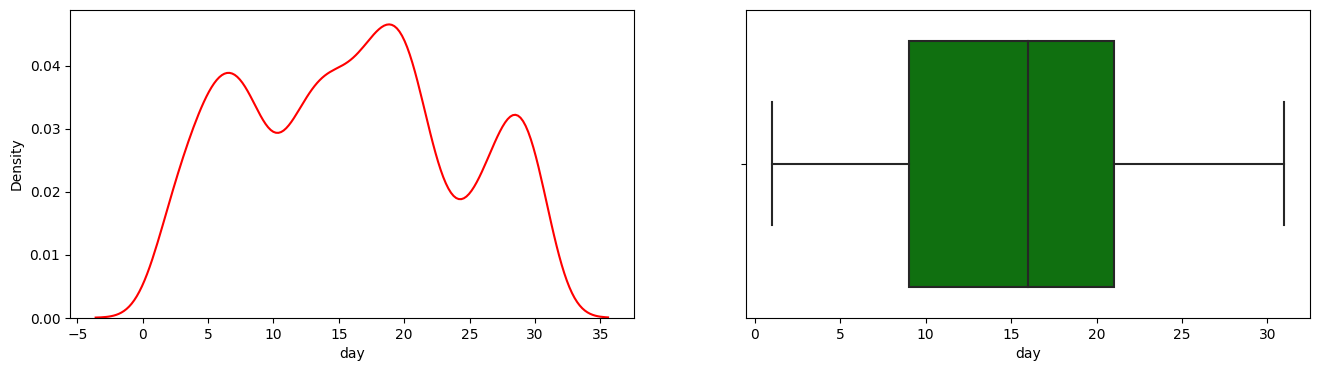

In [23]:
# getting information regarding distribution and outliers of day feature.
get_distribution(df["day"])

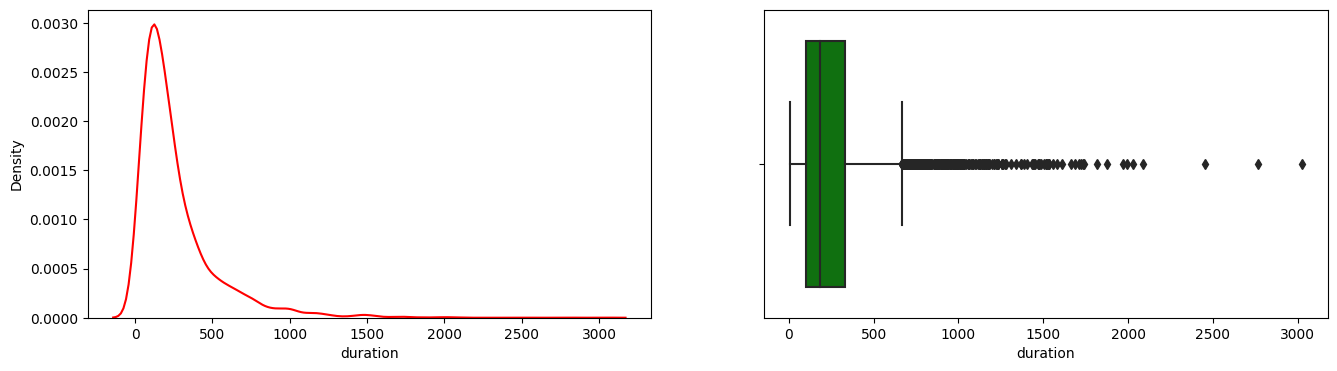

In [24]:
# getting information regarding distribution and outliers of duration feature.
get_distribution(df["duration"])

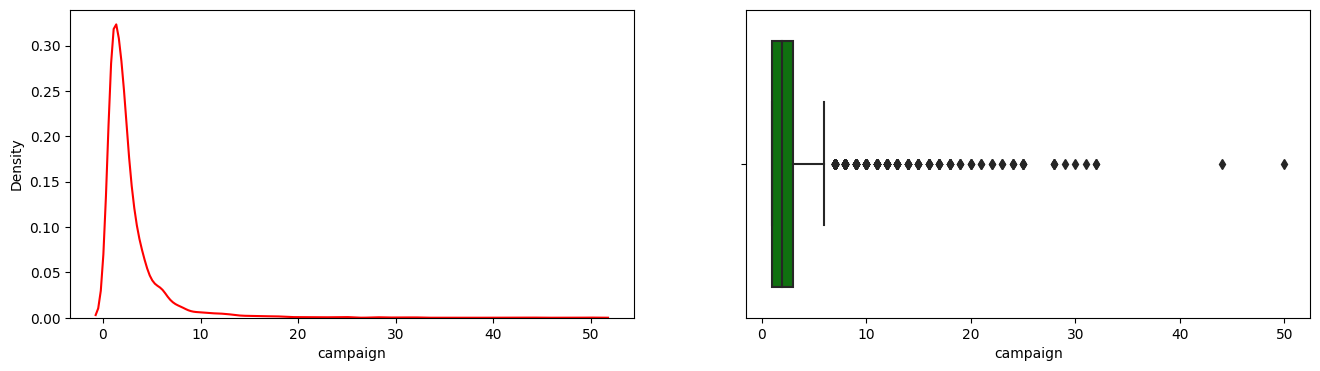

In [25]:
# getting information regarding distribution and outliers of campaign feature.
get_distribution(df["campaign"])

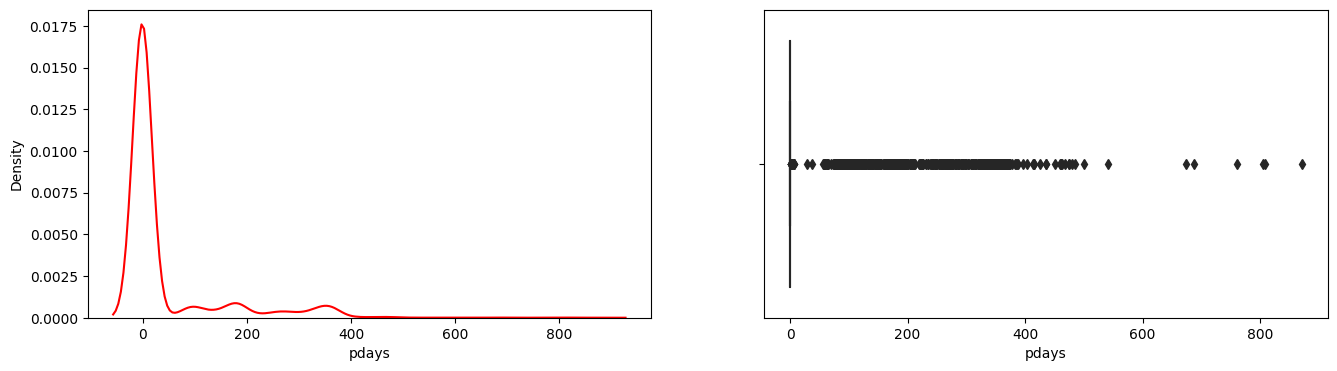

In [26]:
# getting information regarding distribution and outliers of pdays feature.
get_distribution(df["pdays"])

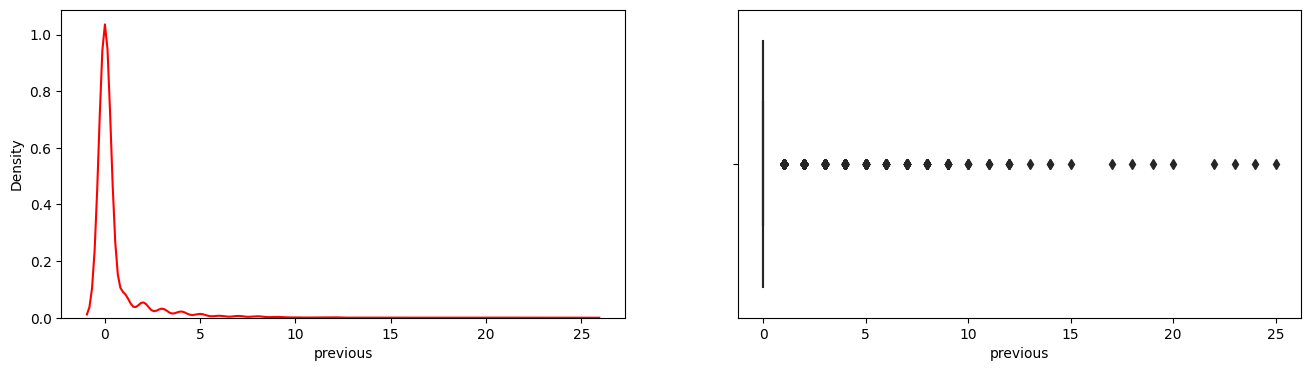

In [27]:
# getting information regarding distribution and outliers of previous feature.
get_distribution(df["previous"])

***Bi & Multi-variate Analysis of the data:***

y
no     40.949358
yes    42.361868
Name: age, dtype: float64


<AxesSubplot: xlabel='y'>

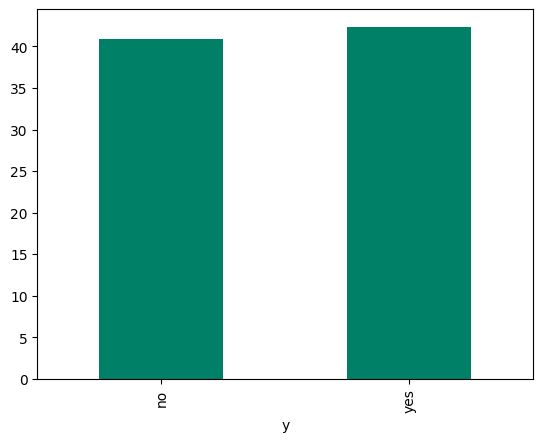

In [28]:
_ = df.groupby("y").mean()["age"]
print(_)
_.plot(kind = "bar", cmap = "summer")

*The average age in each category of target variable is (Yes: 42 years and NO: 40 years)*

In [29]:
df.pivot_table(values = "age", columns = "y",index = "job",aggfunc="mean")

y,no,yes
job,,
admin.,39.471429,41.206897
blue-collar,40.273660,38.666667
entrepreneur,41.993464,42.200000
housemaid,47.571429,45.714286
management,40.763723,39.114504
retired,60.215909,67.259259
self-employed,40.950920,45.550000
services,38.641161,37.868421
student,27.584615,24.210526


*The average age in each category of job for target yes and no.*

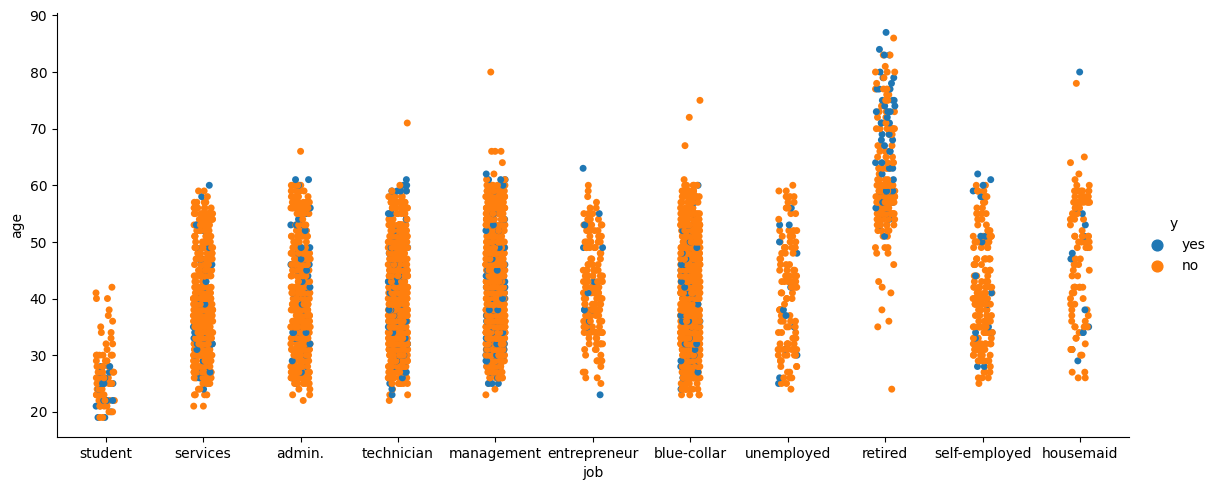

In [30]:
# here is the distribution of ages in each category of job in both of targeted categories.
sns.catplot(data = df, x = "job", y = "age", 
            hue = "y", jitter = 0.1, aspect = 2.3,height = 5)

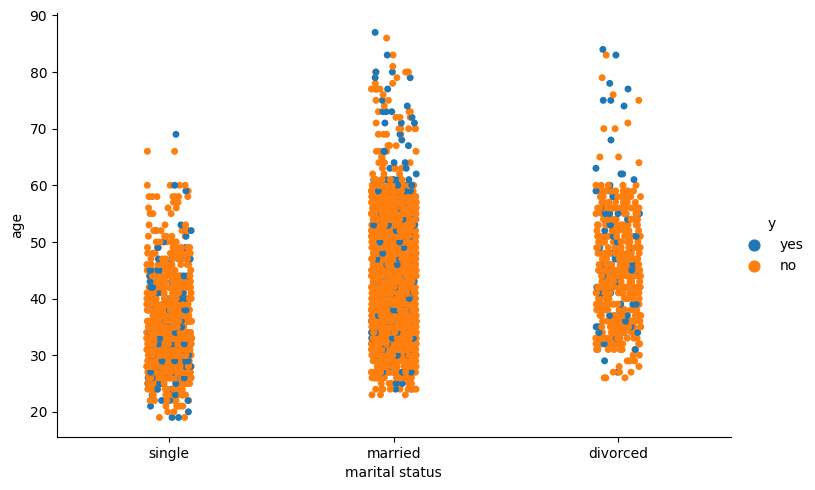

In [31]:
# here is the distribution of ages in each category of marital status in both of targeted categories.
sns.catplot(data = df, x = "marital status", y = "age", 
            hue = "y", jitter = 0.1, aspect = 1.5,height = 5)

In [32]:
# The average age where housing loan and personal loans are no & no / no & yes / yes & no / Yes & Yes respectively.
df.groupby(["housing","loan"],as_index=False)["age"].mean()

,housing,loan,age
0,no,no,43.367073
1,no,yes,43.754386
2,yes,no,39.468184
3,yes,yes,38.851852


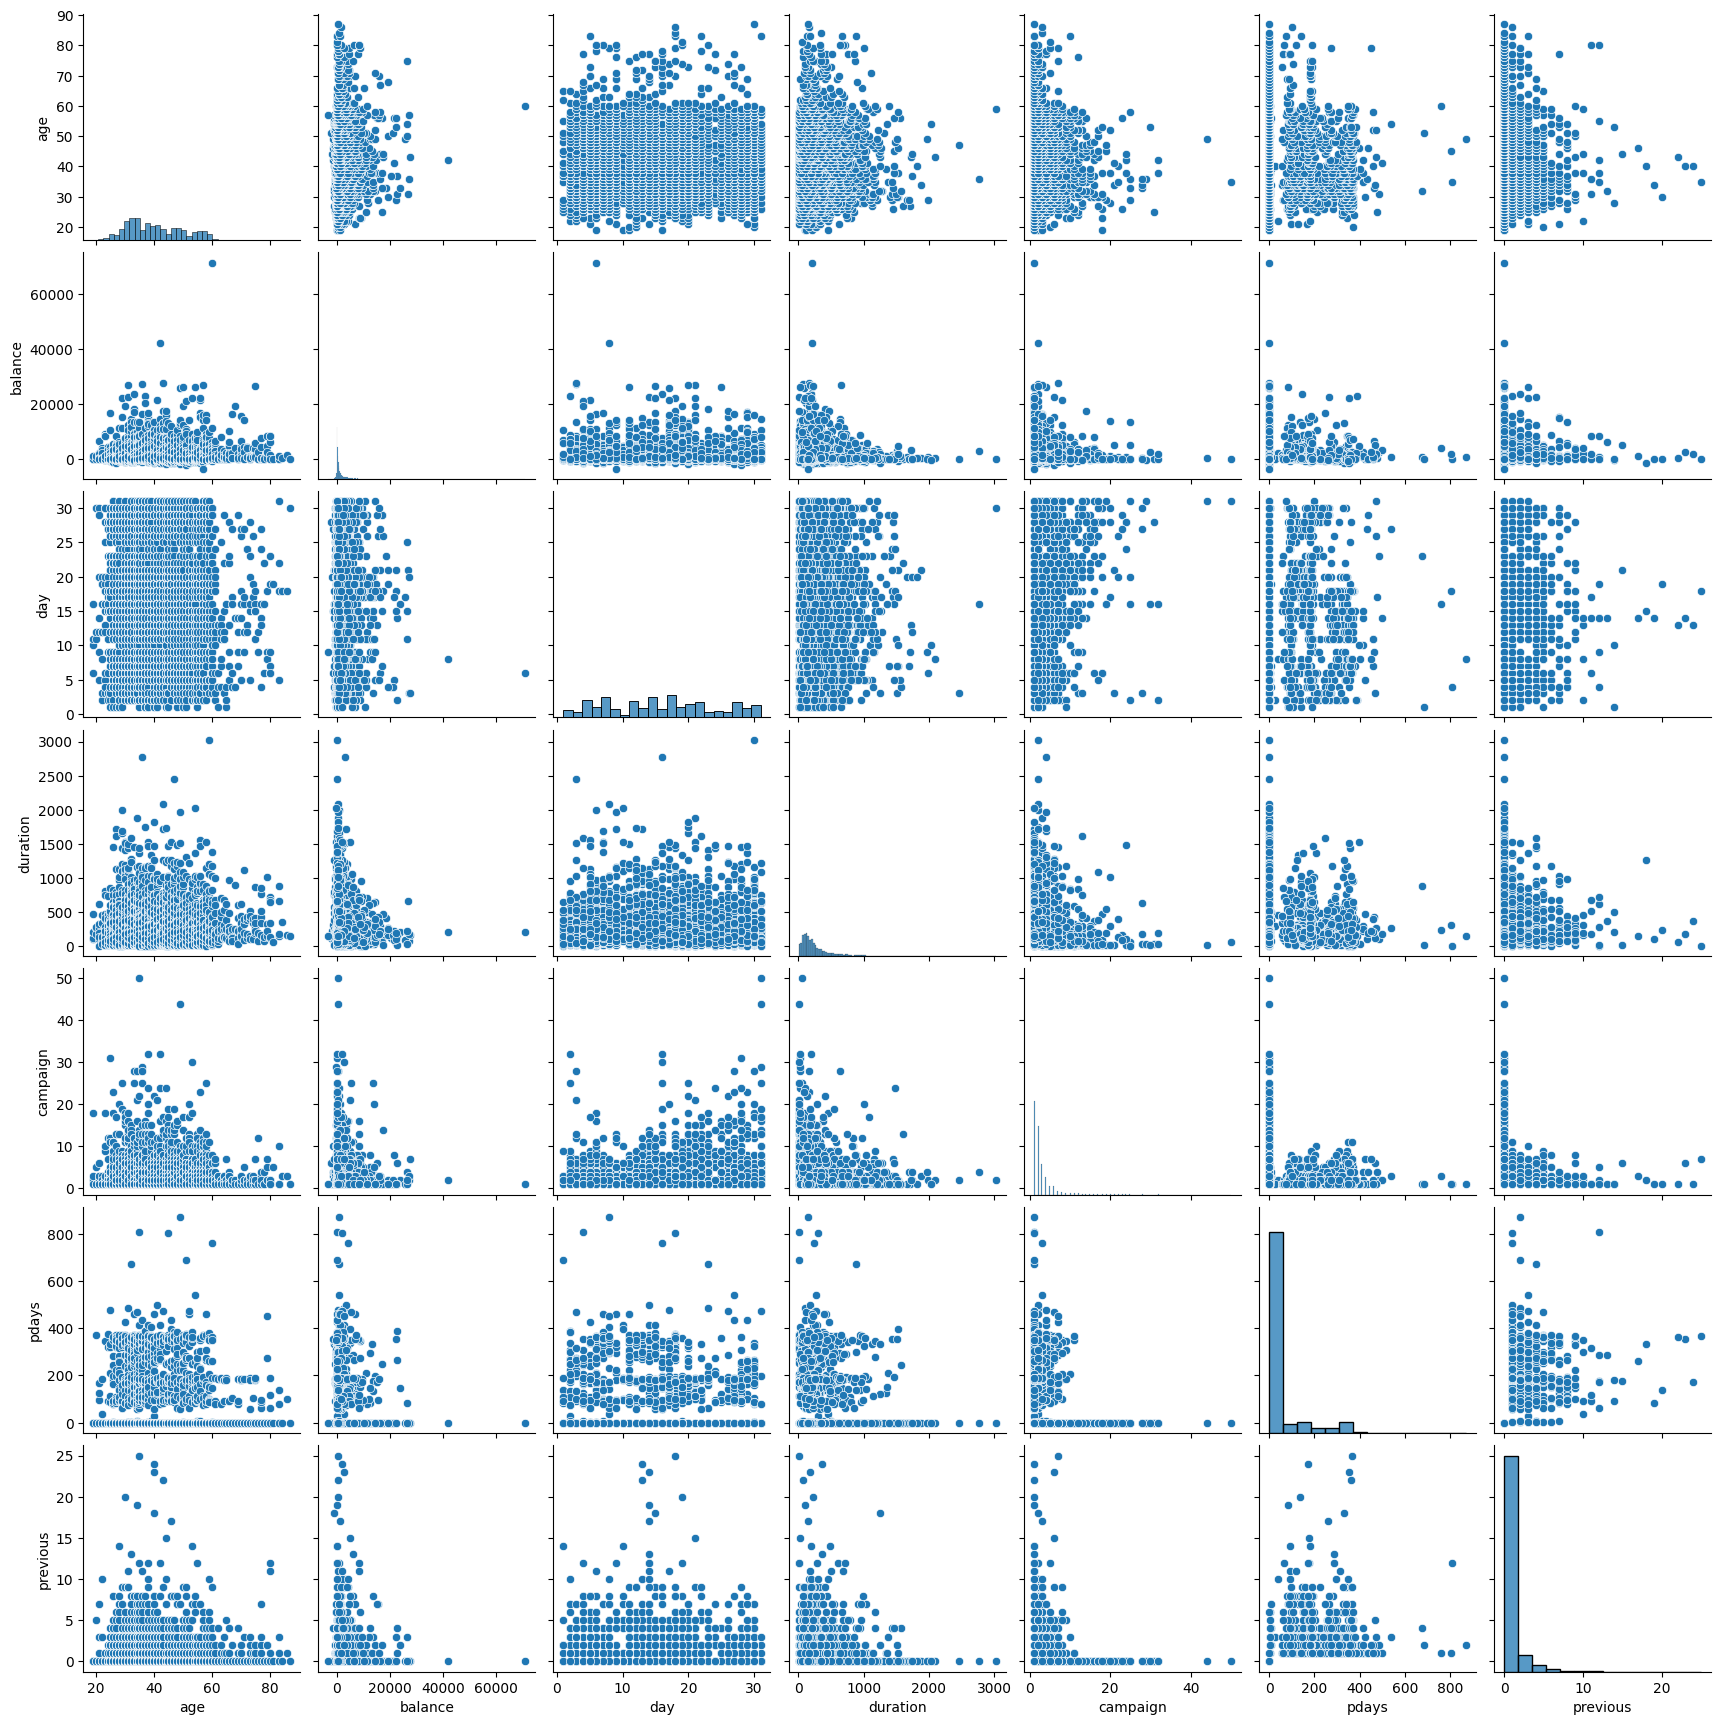

In [33]:
# Getting distribution of data points (checking featuers are related to each other or not)
sns.pairplot(data = df.drop("y",axis = 1))

In [34]:
df[["day", "month","pdays"]].head(5)

,day,month,pdays
0,10,jul,-1
1,11,feb,-1
2,16,jul,-1
3,6,feb,-1
4,30,apr,-1


As we can see the previous days has include all the information regarding when the last contact was done. So we do not need rest of two columns (**day & month**)

<AxesSubplot: xlabel='marital status,y'>

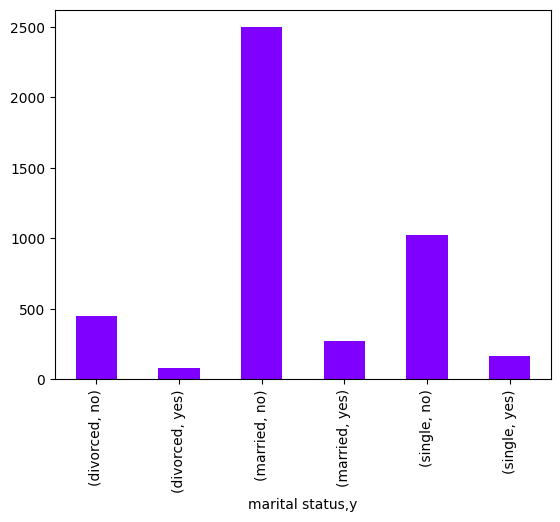

In [35]:
# getting count of categories of marital featuers with categoreis of target features
df.groupby(["marital status","y"])["age"].count().plot(kind = "bar",cmap = "rainbow" )

# *Feature Engineering*

In [52]:
# making a copy of data frame
df1 = df.copy()

In [53]:
# as we have seen that days and months features has same information like pdays. So I decided to drop them
df1.drop(["day","month"],axis =1, inplace = True)

In [54]:
# changing unknown with null values (because "unknown" has no information)
for i in df1.columns:
    df1[i] = np.where(df1[i] == "unknown", np.nan, df1[i])
df1.isna().sum()

age                  0
job                  0
marital status       0
education          172
default              0
balance              0
housing              0
loan                 0
contact           1315
duration             0
campaign             0
pdays                0
previous             0
poutcome          3673
y                    0
dtype: int64

In [55]:
#The percentage of null values in poutcome feature
(3673/df1.poutcome.shape[0])*100

81.93174213696186

In [56]:
#The percentage of null values in contact feature but we can impute the null values of it
(1315/df1.contact.shape[0])*100

29.333035913450818

**As we can see the poutcome has 3705 values null after replacing the unknown with null values. And we will not impute them because the percentage of null values is higher. So, i decided to drop this feature**

In [57]:
# dropping the feature with higher percentage of null values
df1.drop("poutcome", inplace = True, axis = 1)

In [58]:
# We have contact feature with high null values 
# Also, there is no effect either they called by cellular or landline. So, i decided to drop it 
df1.drop("contact", inplace = True, axis = 1)

In [59]:
# in place of label encoder i am using replace function for ordinal data in independent features
df1["education"].replace({'primary':0, 'secondary':1, 'tertiary':2},inplace = True)
df1["default"].replace({'no':0, 'yes':1},inplace = True)
df1["marital status"].replace({'single':0, 'married':1, 'divorced':2},inplace = True)
df1["housing"].replace({'no':0, 'yes':1},inplace = True)
df1["loan"].replace({'no':0, 'yes':1},inplace = True)

In [60]:
# using forward fill method to fill the nan values
df1["job"].fillna(method = "ffill",inplace=True)
df1["education"].fillna(method = "ffill",inplace= True)

In [61]:
# using one hot encoder for nominal data
ohe = OneHotEncoder()
df1[list(df1["job"].unique())] = ohe.fit_transform(df1[["job"]]).A
#df1.drop("job",axis = 1, inplace = True)
df1.head()

,age,job,marital status,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,student,services,admin.,technician,management,entrepreneur,blue-collar,unemployed,retired,self-employed,housemaid
0,19.0,student,0,0.0,0,103.0,0,0,104.0,2.0,-1.0,0.0,yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,19.0,student,0,0.0,0,0.0,0,0,123.0,3.0,-1.0,0.0,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,19.0,student,0,1.0,0,302.0,0,0,205.0,1.0,-1.0,0.0,yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,19.0,student,0,1.0,0,1169.0,0,0,463.0,18.0,-1.0,0.0,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,20.0,student,0,1.0,0,502.0,0,0,261.0,1.0,-1.0,0.0,yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [62]:
# for target variable I am using the label encoder
label = LabelEncoder()
df1["y"] =  label.fit_transform(df1["y"])
df1.head()

,age,job,marital status,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,student,services,admin.,technician,management,entrepreneur,blue-collar,unemployed,retired,self-employed,housemaid
0,19.0,student,0,0.0,0,103.0,0,0,104.0,2.0,-1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,19.0,student,0,0.0,0,0.0,0,0,123.0,3.0,-1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,19.0,student,0,1.0,0,302.0,0,0,205.0,1.0,-1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,19.0,student,0,1.0,0,1169.0,0,0,463.0,18.0,-1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,20.0,student,0,1.0,0,502.0,0,0,261.0,1.0,-1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# *Feature Selection*

<AxesSubplot: >

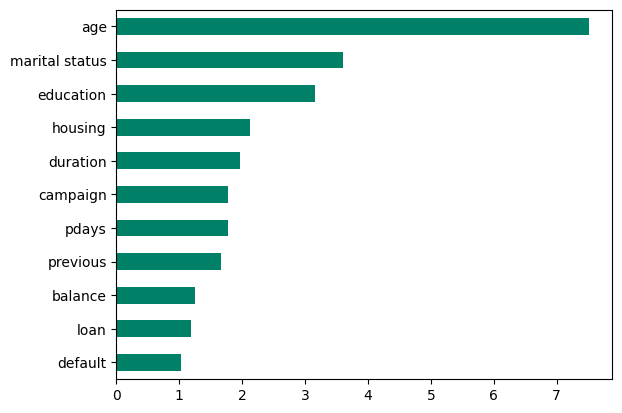

In [63]:
# checking multi co-linearity
b = df1[['age', 'marital status', 'education', 'default', 'balance', 'housing', 'loan',
       'duration', 'campaign', 'pdays', 'previous']]
vif_lst = []
for i in range(b.shape[1]):
    vif = variance_inflation_factor(b.to_numpy(),i)
    vif_lst.append(vif)
s1 = pd.Series(vif_lst, index = b.columns)
s1.sort_values().plot(kind = "barh", cmap = "summer")

***As we can see, all the features are independent from each other. Because the VIF values are less than 5(except age). (I am not considering the one hot encoded featues to drop by seeing VIF)***

<AxesSubplot: >

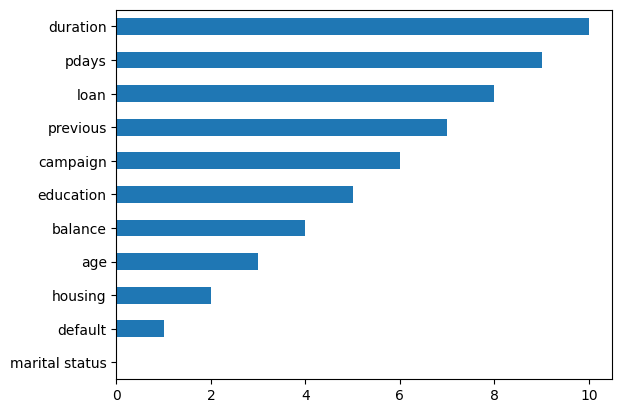

In [66]:
# fisher_score to check participation score of features
fisher_rank = fisher_score.fisher_score(b.to_numpy(),df1["y"])
s = pd.Series(fisher_rank, index =b.columns)
s.sort_values().plot(kind = "barh")

***fisher score telling that marital feature is not participating***

In [67]:
# checking variance threshold 
var_th = VarianceThreshold(threshold = 0.0)
var_th.fit_transform(b)
s = pd.Series(var_th.get_support(),index = b.columns)
s

age               True
marital status    True
education         True
default           True
balance           True
housing           True
loan              True
duration          True
campaign          True
pdays             True
previous          True
dtype: bool

***It is providing True for all the features, which states that all the features are good predictors.***

In [68]:
# Chi2 test (between categorical featues)
_temp = df1[['marital status', 'education', 'default', 'housing', 'loan',
        'campaign', 'previous']]
chi, p_val = chi2(_temp,df1["y"])
s = pd.DataFrame({"Chi2":np.around(chi,2), "P_val": np.around(p_val,2)}, index = _temp.columns)
s

,Chi2,P_val
marital status,0.44,0.51
education,4.81,0.03
default,0.01,0.92
housing,21.25,0.00
loan,19.66,0.00
campaign,56.87,0.00
previous,308.15,0.00


***Chi2 test stats that marital and default features are not important for the model.***

chi2 is low and p value is high (means variable is independent from the target feature)

In [69]:
# taking annova test (continuous vs categorical features)
_temp = df1[['age', 'balance', 'duration', 'pdays']]
f_val,p_val = f_classif(_temp,df1["y"])
pd.DataFrame({"F_Val": np.around(f_val,2), "P_val": np.around(p_val,2)},index = _temp.columns)

,F_Val,P_val
age,8.16,0.00
balance,1.49,0.22
duration,861.29,0.00
pdays,44.13,0.00


***Here we can see the balance featuer is not important***

(f value is low) and (p value is greather than 0.05) means bad predicter

**Dropping the feature**

we have avidance by fisher score and chi2 test that marital is not a good predictor. So I decided to drop it.


In [70]:
df1.drop("marital status",inplace = True,axis=1)

In [71]:
df1.head()

,age,job,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,student,services,admin.,technician,management,entrepreneur,blue-collar,unemployed,retired,self-employed,housemaid
0,19.0,student,0.0,0,103.0,0,0,104.0,2.0,-1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,19.0,student,0.0,0,0.0,0,0,123.0,3.0,-1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,19.0,student,1.0,0,302.0,0,0,205.0,1.0,-1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,19.0,student,1.0,0,1169.0,0,0,463.0,18.0,-1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,20.0,student,1.0,0,502.0,0,0,261.0,1.0,-1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [72]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4483 entries, 0 to 4482
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            4483 non-null   float64
 1   job            4483 non-null   object 
 2   education      4483 non-null   float64
 3   default        4483 non-null   int64  
 4   balance        4483 non-null   float64
 5   housing        4483 non-null   int64  
 6   loan           4483 non-null   int64  
 7   duration       4483 non-null   float64
 8   campaign       4483 non-null   float64
 9   pdays          4483 non-null   float64
 10  previous       4483 non-null   float64
 11  y              4483 non-null   int32  
 12  student        4483 non-null   float64
 13  services       4483 non-null   float64
 14  admin.         4483 non-null   float64
 15  technician     4483 non-null   float64
 16  management     4483 non-null   float64
 17  entrepreneur   4483 non-null   float64
 18  blue-col

# *Model Selection*

In [73]:
x = df1.drop("y",axis = 1)
y = df1["y"]

In [74]:
# spliting the data for training as well as testing purposes.
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.25, random_state=42, stratify=y)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3362, 22)
(3362,)
(1121, 22)
(1121,)


### *Balancing The Data*

In [ ]:
# First we have to balance the data for training (I am using SMOTE)
sm = SMOTE(sampling_strategy=0.75)
sm_x,sm_y = sm.fit_resample(x_train,y_train)

In [58]:
print(f"First we have the value counts:\n{y_train.value_counts()}\n\nAfter OverSampling now we have value counts:\n{sm_y.value_counts()}")

First we have the value counts:
0    3199
1     417
Name: y, dtype: int64

After OverSampling now we have value counts:
0    3199
1    2399
Name: y, dtype: int64


#### *Scaling the data*

In [59]:
#for scaling I am using standard scaler as It has 0 mean and 1 standard deviation
std = StandardScaler()
arr = std.fit_transform(sm_x)
std_x = pd.DataFrame(arr, columns = sm_x.columns)
std_x.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,unemployed,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,-0.902527,-0.294315,8.822985,-0.553286,1.161525,-0.336039,-0.621832,0.139963,-0.480895,-0.420852,3.071969,-0.501757,-0.202795,-0.177448,-0.595318,-0.285363,-0.214769,-0.322829,-0.174065,-0.478998,-0.180137
1,-0.713125,1.299595,-0.113340,-0.493041,1.161525,2.975842,-0.771419,-0.585008,0.368693,10.859073,-0.369841,-0.501757,-0.202795,-0.177448,-0.595318,-0.285363,-0.214769,-0.322829,-0.174065,2.374765,-0.180137
2,0.233882,1.299595,-0.113340,-0.546592,-0.860937,-0.336039,-0.918072,-0.222523,-0.480895,-0.420852,-0.369841,-0.501757,-0.202795,-0.177448,1.931833,-0.285363,-0.214769,-0.322829,-0.174065,-0.478998,-0.180137
3,-0.713125,-0.294315,-0.113340,2.543413,1.161525,2.975842,-0.929805,-0.585008,-0.480895,-0.420852,-0.369841,2.179589,-0.202795,-0.177448,-0.595318,-0.285363,-0.214769,-0.322829,-0.174065,-0.478998,-0.180137
4,0.896787,-1.888225,-0.113340,1.331435,-0.860937,2.975842,-0.856478,1.589905,-0.480895,-0.420852,-0.369841,2.179589,-0.202795,-0.177448,-0.595318,-0.285363,-0.214769,-0.322829,-0.174065,-0.478998,-0.180137


In [60]:
# Scaling the testing data
arr1 = std.transform(x_test)
std_x_te = pd.DataFrame(arr1, columns = x_test.columns)
std_x_te.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,unemployed,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,1.654393,-1.888225,-0.11334,0.095656,-0.860937,-0.336039,0.390078,0.502449,3.065641,0.766508,-0.369841,-0.501757,-0.202795,-0.177448,1.931833,-0.285363,-0.214769,-0.322829,-0.174065,-0.478998,-0.180137
1,-0.144921,-0.294315,-0.11334,-0.506057,-0.860937,-0.336039,0.102637,7.027190,-0.480895,-0.420852,-0.369841,-0.501757,-0.202795,-0.177448,-0.595318,-0.285363,-0.214769,-0.322829,-0.174065,2.374765,-0.180137
2,0.233882,-0.294315,-0.11334,-0.383706,1.161525,-0.336039,-0.967935,0.139963,2.522300,0.172828,-0.369841,-0.501757,-0.202795,-0.177448,1.931833,-0.285363,-0.214769,-0.322829,-0.174065,-0.478998,-0.180137
3,-1.186629,-1.888225,-0.11334,-0.584525,-0.860937,-0.336039,-0.683427,-0.585008,-0.480895,-0.420852,-0.369841,-0.501757,-0.202795,-0.177448,-0.595318,-0.285363,-0.214769,3.472590,-0.174065,-0.478998,-0.180137
4,1.086189,1.299595,-0.11334,-0.492297,-0.860937,-0.336039,-0.636497,-0.585008,-0.480895,-0.420852,-0.369841,-0.501757,-0.202795,-0.177448,1.931833,-0.285363,-0.214769,-0.322829,-0.174065,-0.478998,-0.180137


#### *Selecting the model*

In [61]:
lst = [("LogisticRegression",LogisticRegression()),
       ("KNN Classifier", KNeighborsClassifier()),
       ("RandomForest",RandomForestClassifier()),
      ("AdaBoost",AdaBoostClassifier()),
      ("XGBoost",XGBClassifier())]
for name,model in lst:
    model.fit(std_x,sm_y)
    y1 = model.predict(std_x)
    accuracy = accuracy_score(sm_y,y1)
    y2 = model.predict(std_x_te)
    acc_te = accuracy_score(y_test,y2)
    print(f"For {name}::\nThe Training Accuracy is: {accuracy}\nThe Testing Accuracy is: {acc_te}")
    print("--"*40)

For LogisticRegression::
The Training Accuracy is: 0.8317256162915327
The Testing Accuracy is: 0.8232044198895028
--------------------------------------------------------------------------------
For KNN Classifier::
The Training Accuracy is: 0.9274740978921043
The Testing Accuracy is: 0.8552486187845304
--------------------------------------------------------------------------------
For RandomForest::
The Training Accuracy is: 1.0
The Testing Accuracy is: 0.8895027624309392
--------------------------------------------------------------------------------
For AdaBoost::
The Training Accuracy is: 0.912647374062165
The Testing Accuracy is: 0.876243093922652
--------------------------------------------------------------------------------
For XGBoost::
The Training Accuracy is: 0.9946409431939979
The Testing Accuracy is: 0.8839779005524862
--------------------------------------------------------------------------------


### *As we can see that, we are getting good accuracy in xgboost model. So, we will move forward with xgbclassifier model.*

### *Tuning The Model*

In [62]:
estimator = XGBClassifier()
parameters = {"n_estimators": [50,100,150,200,250,300,350,400],
             "max_depth": np.arange(2,10),
             "learning_rate": np.arange(0.01,0.1,0.02),
             'subsample': np.arange(0.5, 1.0, 0.1),
             'colsample_bytree': np.arange(0.4, 1.0, 0.1),
             'colsample_bylevel': np.arange(0.4, 1.0, 0.1)}
rscv = RandomizedSearchCV(estimator, parameters, cv = 5, random_state= 42)
rscv.fit(std_x,sm_y)
rscv.best_params_

{'subsample': 0.5,
 'n_estimators': 300,
 'max_depth': 6,
 'learning_rate': 0.08999999999999998,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.4}

#### *Training The Model*

In [63]:
xgb = XGBClassifier(subsample = 0.5, n_estimators = 150,
                    max_depth = 7, learning_rate = 0.049999999999999996,
                    colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.5)
xgb.fit(std_x,sm_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1,
              colsample_bytree=0.7999999999999999, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.049999999999999996,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=7,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [64]:
# checking the performance of the model at Training time
y_pr_train = xgb.predict(std_x)
acc_train = accuracy_score(sm_y,y_pr_train)
class_re = classification_report(sm_y,y_pr_train)
con_mat = confusion_matrix(sm_y,y_pr_train)
print("Confusion Matrix:\n",con_mat)
print("\n")
print("The accuracy of the model:",(acc_train)*100)
print("\n")
print("The classification report:\n",class_re)

Confusion Matrix:
 [[3139   60]
 [ 158 2241]]


The accuracy of the model: 96.1057520543051


The classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      3199
           1       0.97      0.93      0.95      2399

    accuracy                           0.96      5598
   macro avg       0.96      0.96      0.96      5598
weighted avg       0.96      0.96      0.96      5598



In [65]:
# checking the performance of the model at Testing time
y_pr_test = xgb.predict(std_x_te)
acc_test = accuracy_score(y_test,y_pr_test)
class_re1 = classification_report(y_test,y_pr_test)
con_mat1 = confusion_matrix(y_test,y_pr_test)
print("Confusion Matrix:\n",con_mat1)
print("\n")
print("The accuracy of the model:",(acc_test)*100)
print("\n")
print("The classification report:\n",class_re1)

Confusion Matrix:
 [[759  42]
 [ 67  37]]


The accuracy of the model: 87.95580110497238


The classification report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       801
           1       0.47      0.36      0.40       104

    accuracy                           0.88       905
   macro avg       0.69      0.65      0.67       905
weighted avg       0.87      0.88      0.87       905



**As we can see our accuracy is quite good and also we are getting good tread-off between testing and training accuracies**

<AxesSubplot:>

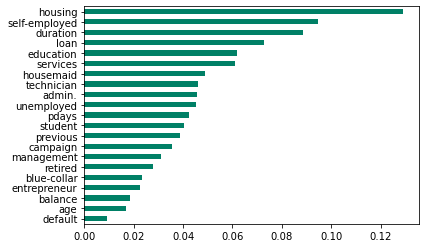

In [66]:
# Now checking the importances of the featues
s = pd.Series(xgb.feature_importances_,sm_x.columns)
s.sort_values().plot(kind = "barh",cmap = "summer")

**Here we can see all the features are participating in the model**

Text(0.5, 1.0, 'ROC - AUC CURVE')

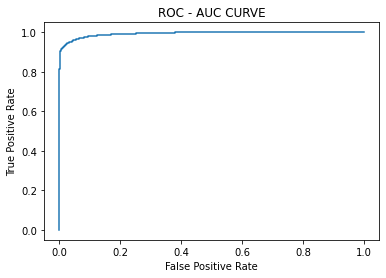

In [67]:
# Checking roc_curve
y_prob = xgb.predict_proba(std_x)
y_pr   = y_prob[:,1]
fpr,tpr,threshold = roc_curve(sm_y,y_pr)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - AUC CURVE")
    